### 1. Import Dependencies

In [63]:
import string
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from snowballstemmer import stemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yonti's\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yonti's\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2. Preprocessing

In [64]:
import pandas as pd

df = pd.read_csv('data/twitter.csv')

df.head()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       300 non-null    object
 1   sentiment  300 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


In [65]:
import random

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

# Create a new dataframe with a random sample of 100 rows from each class
data = pd.concat([df[df['sentiment']==0].sample(n=100), 
                  df[df['sentiment']==1].sample(n=100), 
                  df[df['sentiment']==2].sample(n=100)])

# Reset the index of the new dataframe
data = data.reset_index(drop=True)

# Display the value counts of the sentiment column in the new dataframe
display(data['sentiment'].value_counts())
data.head() # Show dataframe

sentiment
0    100
1    100
2    100
Name: count, dtype: int64

,text,sentiment
0,kalian ptm nnti pulang jam brp?,0
1,ini kok skolah ku tdk ada ptm,0
2,mau brkgt ptm,0
3,oh ini yg kmrn pamer dia masuk besok trny dia ...,0
4,yg dom jabodetabek kalian ptm nya udah 100% kah?,0


In [66]:
data['lower_text']=data['text'].str.lower()  # Convert to lowercase
data['remove_url']=data['lower_text'].apply(lambda x: re.sub(r"http\S+", "", x))    # remove url
data['remove_num']=data['remove_url'].apply(lambda x: re.sub(r'\d+', '', x))    # Remove number
data['punctuation']=data['remove_num'].apply(lambda x: re.sub(r'[^\w\s]', '', x))    # Remove punctuation
data['tokenized_text']=data['punctuation'].apply(nltk.word_tokenize) # Tokenize the text

# Get the Indonesian stopwords
indonesian_stopwords = set(nltk.corpus.stopwords.words('indonesian'))

# Remove the stopwords from the tokenized texts
data['stopwords']=data['tokenized_text'].apply(lambda x: [w for w in x if not w in indonesian_stopwords])

# Initialize the Porter stemmer
stemmer = stemmer('indonesian')

# Stem the tokenized texts in the 'stopwords' column of the dataframe
data['stemmed']=data['stopwords'].apply(lambda x: stemmer.stemWords(x))

data['normalized']=data['stemmed'].apply(lambda x: ' '.join(x)) # Join the stemmed words into a single string

In [67]:
data.head()

,text,sentiment,lower_text,remove_url,remove_num,punctuation,tokenized_text,stopwords,stemmed,normalized
0,kalian ptm nnti pulang jam brp?,0,kalian ptm nnti pulang jam brp?,kalian ptm nnti pulang jam brp?,kalian ptm nnti pulang jam brp?,kalian ptm nnti pulang jam brp,"[kalian, ptm, nnti, pulang, jam, brp]","[ptm, nnti, pulang, jam, brp]","[ptm, nnti, pulang, jam, brp]",ptm nnti pulang jam brp
1,ini kok skolah ku tdk ada ptm,0,ini kok skolah ku tdk ada ptm,ini kok skolah ku tdk ada ptm,ini kok skolah ku tdk ada ptm,ini kok skolah ku tdk ada ptm,"[ini, kok, skolah, ku, tdk, ada, ptm]","[skolah, ku, tdk, ptm]","[skolah, ku, tdk, ptm]",skolah ku tdk ptm
2,mau brkgt ptm,0,mau brkgt ptm,mau brkgt ptm,mau brkgt ptm,mau brkgt ptm,"[mau, brkgt, ptm]","[brkgt, ptm]","[brkgt, ptm]",brkgt ptm
3,oh ini yg kmrn pamer dia masuk besok trny dia ...,0,oh ini yg kmrn pamer dia masuk besok trny dia ...,oh ini yg kmrn pamer dia masuk besok trny dia ...,oh ini yg kmrn pamer dia masuk besok trny dia ...,oh ini yg kmrn pamer dia masuk besok trny dia ...,"[oh, ini, yg, kmrn, pamer, dia, masuk, besok, ...","[oh, yg, kmrn, pamer, masuk, besok, trny, ptm,...","[oh, yg, kmrn, pamer, masuk, besok, trny, ptm,...",oh yg kmrn pamer masuk besok trny ptm daring c...
4,yg dom jabodetabek kalian ptm nya udah 100% kah?,0,yg dom jabodetabek kalian ptm nya udah 100% kah?,yg dom jabodetabek kalian ptm nya udah 100% kah?,yg dom jabodetabek kalian ptm nya udah % kah?,yg dom jabodetabek kalian ptm nya udah kah,"[yg, dom, jabodetabek, kalian, ptm, nya, udah,...","[yg, dom, jabodetabek, ptm, nya, udah, kah]","[yg, dom, jabodetabek, ptm, nya, udah, kah]",yg dom jabodetabek ptm nya udah kah


In [68]:
data['freq_token']=data['tokenized_text'].apply(nltk.FreqDist).apply(lambda x: dict(x)) # Frequency word token

data['freq_token']

0      {'kalian': 1, 'ptm': 1, 'nnti': 1, 'pulang': 1...
1      {'ini': 1, 'kok': 1, 'skolah': 1, 'ku': 1, 'td...
2                       {'mau': 1, 'brkgt': 1, 'ptm': 1}
3      {'oh': 1, 'ini': 1, 'yg': 1, 'kmrn': 1, 'pamer...
4      {'yg': 1, 'dom': 1, 'jabodetabek': 1, 'kalian'...
                             ...                        
295    {'sekolah': 1, 'lagi': 2, 'ngen': 1, 'ptm': 1,...
296    {'jam': 2, 'segini': 1, 'aja': 1, 'udah': 1, '...
297    {'jujur': 1, 'gue': 1, 'pusingg': 1, 'hari': 1...
298    {'besoook': 1, 'ptm': 1, 'pulangnya': 1, 'lebi...
299    {'wah': 1, 'di': 1, 'qrt': 1, 'ka': 1, 'fisaa'...
Name: freq_token, Length: 300, dtype: object

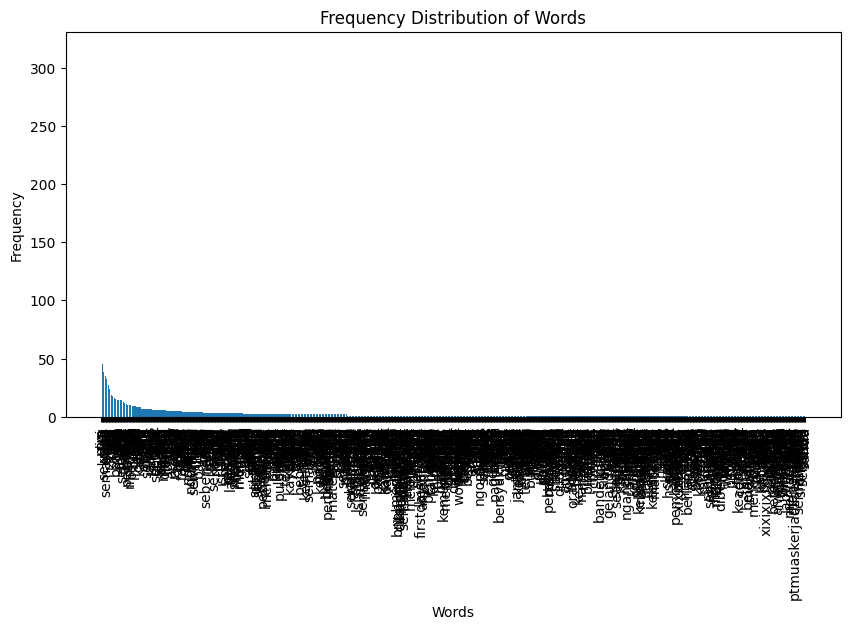

In [69]:
freq_dist = data['freq_token'].apply(pd.Series).fillna(0).sum().sort_values(ascending=False)

# Create bar chart
plt.figure(figsize=(10, 5))
plt.bar(freq_dist.index, freq_dist.values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Words')
plt.xticks(rotation=90)
plt.show()

### 3. TF-IDF Vectorizer

In [70]:
from sklearn.model_selection import train_test_split

# Split data random 80%
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

print("Train: ",X_train.shape,y_train.shape,"Test: ",(X_test.shape,y_test.shape))

Train:  (240,) (240,) Test:  ((60,), (60,))


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create Tfidf vectorizer
vectorizer = TfidfVectorizer()

# Convert the 'review' column into its TF-IDF vectorized form
X = vectorizer.fit_transform(data['normalized'])


In [72]:
# Get the feature names (terms) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the tf-idf scores for each term
tfidf_scores = vectorizer.idf_

# Create a DataFrame to store the results
results = pd.DataFrame({
    'term': feature_names,
    'tf': X.sum(axis=0).tolist()[0],  # sum up the term frequencies for each term
    'tf-idf': tfidf_scores  # use the pre-computed tf-idf scores
})

# Sort the DataFrame by the tf-idf scores in descending order
results = results.sort_values('tf-idf', ascending=False)

# Print the results
print(results)

         term         tf    tf-idf
0         aaa   0.449934  6.013963
452       mon   0.421227  6.013963
443     mikir   0.303024  6.013963
446    miring   0.232769  6.013963
447    mleyot   0.330950  6.013963
..        ...        ...       ...
607  semangat  13.566570  3.305913
597      seko   9.025417  3.069524
715      udah  11.802075  3.043549
748        yg  11.840617  2.993538
553       ptm  32.635561  1.003328

[756 rows x 3 columns]


In [73]:
# Convert the sparse matrix X into a 2D array of term frequencies
term_freqs = X.toarray()

# Convert the term frequencies array into a DataFrame
term_freqs_df = pd.DataFrame(term_freqs, columns=feature_names)

# Print the term frequencies for each document
print(term_freqs_df)

     aaa  aaaa  aaaatt  aaakkk  aamiin  abieezzz  abis  absen  ada  adaa  ...  \
0    0.0   0.0     0.0     0.0     0.0       0.0   0.0    0.0  0.0   0.0  ...   
1    0.0   0.0     0.0     0.0     0.0       0.0   0.0    0.0  0.0   0.0  ...   
2    0.0   0.0     0.0     0.0     0.0       0.0   0.0    0.0  0.0   0.0  ...   
3    0.0   0.0     0.0     0.0     0.0       0.0   0.0    0.0  0.0   0.0  ...   
4    0.0   0.0     0.0     0.0     0.0       0.0   0.0    0.0  0.0   0.0  ...   
..   ...   ...     ...     ...     ...       ...   ...    ...  ...   ...  ...   
295  0.0   0.0     0.0     0.0     0.0       0.0   0.0    0.0  0.0   0.0  ...   
296  0.0   0.0     0.0     0.0     0.0       0.0   0.0    0.0  0.0   0.0  ...   
297  0.0   0.0     0.0     0.0     0.0       0.0   0.0    0.0  0.0   0.0  ...   
298  0.0   0.0     0.0     0.0     0.0       0.0   0.0    0.0  0.0   0.0  ...   
299  0.0   0.0     0.0     0.0     0.0       0.0   0.0    0.0  0.0   0.0  ...   

     yaudah  yaww        yg

### 4. Train and Evaluate Data

In [74]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [75]:
# Convert training and test datasets into vectorized form
X_train_vectorized =  vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Create a Multinomial Naive Bayes model
model = MultinomialNB(alpha=1)

# Train the model
model.fit(X_train_vectorized, y_train)

# Predict sentiment for test dataset
y_pred = model.predict(X_test_vectorized)

report=classification_report(y_test, y_pred,output_dict=True)
print(pd.DataFrame(report).transpose())

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred, normalize=True)
print(f'\nAccuracy of the model: {accuracy*100:.2f}%')

              precision    recall  f1-score    support
0              0.478261  0.611111  0.536585  18.000000
1              0.650000  0.650000  0.650000  20.000000
2              0.588235  0.454545  0.512821  22.000000
accuracy       0.566667  0.566667  0.566667   0.566667
macro avg      0.572165  0.571886  0.566469  60.000000
weighted avg   0.575831  0.566667  0.565676  60.000000

Accuracy of the model: 56.67%
